In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", palette="Set2")
PROCESSED = "../data/processed/"

In [18]:
df = pd.read_csv(f"{PROCESSED}master_integrated.csv")
print(f"Shape  : {df.shape}")
print(f"Regions: {sorted(df['region'].unique())}")
print(f"Years  : {sorted(df['year'].unique())}")
print(f"Range  : {df['year_month'].min()} → {df['year_month'].max()}")

Shape  : (108, 24)
Regions: ['PL-Central', 'PL-North', 'PL-South']
Years  : [2022, 2023, 2024]
Range  : 2022-01 → 2024-12


In [19]:
# Pearson correlation (check normality first)
stat_hrs,  p_hrs  = stats.shapiro(df["health_risk_score"])
stat_unit, p_unit = stats.shapiro(df["total_units_sold"])

print(f"\nNormality Test (Shapiro-Wilk):")
print(f"  health_risk_score  : W={stat_hrs:.3f}, p={p_hrs:.4f} → "
      f"{'Normal' if p_hrs > 0.05 else 'Non-normal'}")
print(f"  total_units_sold   : W={stat_unit:.3f}, p={p_unit:.4f} → "
      f"{'Normal' if p_unit > 0.05 else 'Non-normal'}")

# Use Spearman if either non-normal, Pearson if both normal
if p_hrs > 0.05 and p_unit > 0.05:
    corr, pval = stats.pearsonr(df["health_risk_score"], df["total_units_sold"])
    method = "Pearson"
else:
    corr, pval = stats.spearmanr(df["health_risk_score"], df["total_units_sold"])
    method = "Spearman"

print(f"\n{method} Correlation:")
print(f"  r       = {corr:.4f}")
print(f"  p-value = {pval:.4f}")
print(f"  Result  : {'Statistically significant' if pval < 0.05 else 'Not significant'}")
print(f"\nInterpretation:")
if abs(corr) >= 0.5:
    strength = "strong"
elif abs(corr) >= 0.3:
    strength = "moderate"
else:
    strength = "weak"
direction = "positive" if corr > 0 else "negative"
print(f"  → {strength.title()} {direction} correlation between health risk and sales volume")
print(f"  → Regions with higher health burden show {'higher' if corr > 0 else 'lower'} "
      f"product demand")

# Also check HRS vs revenue
corr_rev, pval_rev = stats.spearmanr(df["health_risk_score"], df["total_revenue"])
print(f"\nHRS vs Revenue: r={corr_rev:.4f}, p={pval_rev:.4f}")


Normality Test (Shapiro-Wilk):
  health_risk_score  : W=0.793, p=0.0000 → Non-normal
  total_units_sold   : W=0.920, p=0.0000 → Non-normal

Spearman Correlation:
  r       = -0.2959
  p-value = 0.0019
  Result  : Statistically significant

Interpretation:
  → Weak negative correlation between health risk and sales volume
  → Regions with higher health burden show lower product demand

HRS vs Revenue: r=-0.3054, p=0.0013


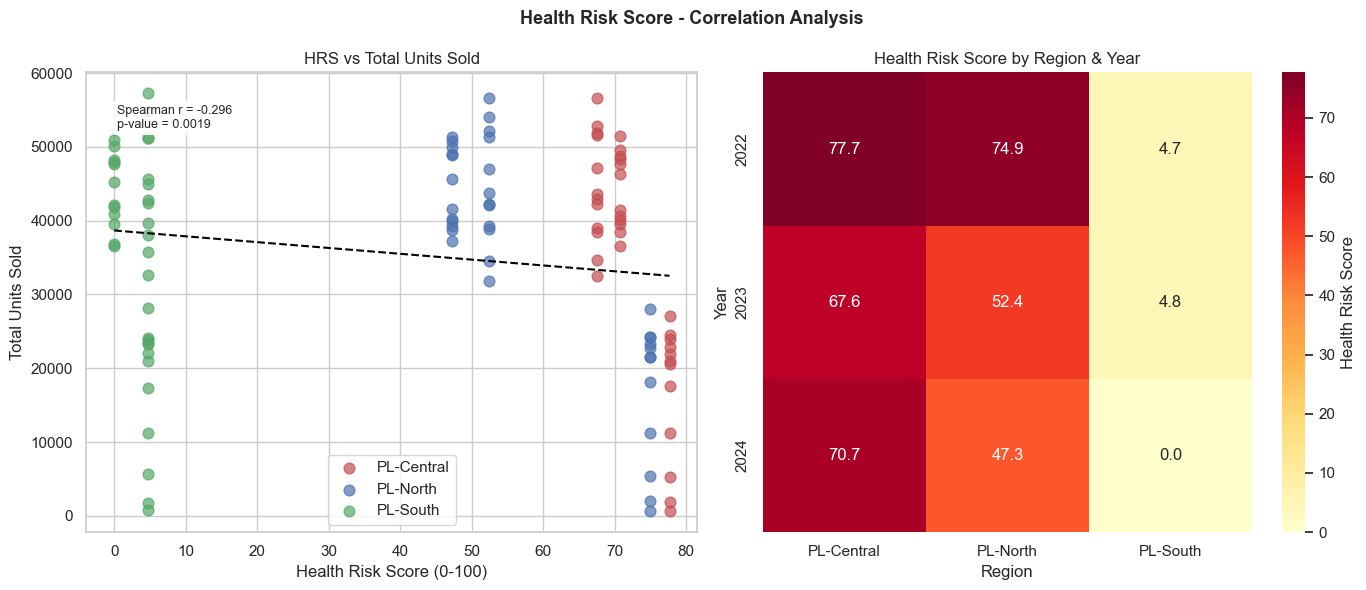

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Health Risk Score - Correlation Analysis", fontsize=13, fontweight="bold")

# Scatter: HRS vs Units Sold
colors_map = {"PL-Central": "#C44E52", "PL-North": "#4C72B0", "PL-South": "#55A868"}
for region, grp in df.groupby("region"):
    axes[0].scatter(grp["health_risk_score"], grp["total_units_sold"],
                    label=region, alpha=0.7, s=60, color=colors_map.get(region, "grey"))

# Regression line
m, b = np.polyfit(df["health_risk_score"], df["total_units_sold"], 1)
x_line = np.linspace(df["health_risk_score"].min(), df["health_risk_score"].max(), 100)
axes[0].plot(x_line, m * x_line + b, color="black", linestyle="--", linewidth=1.5)
axes[0].annotate(
    f"{method} r = {corr:.3f}\np-value = {pval:.4f}",
    xy=(0.05, 0.88), xycoords="axes fraction",
    fontsize=9, bbox=dict(boxstyle="round", fc="white", alpha=0.85)
)
axes[0].set_title("HRS vs Total Units Sold")
axes[0].set_xlabel("Health Risk Score (0-100)")
axes[0].set_ylabel("Total Units Sold")
axes[0].legend()

# Heatmap: HRS by region × year
pivot = df.groupby(["year", "region"])["health_risk_score"].mean().unstack()
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="YlOrRd",
            ax=axes[1], cbar_kws={"label": "Health Risk Score"})
axes[1].set_title("Health Risk Score by Region & Year")
axes[1].set_xlabel("Region")
axes[1].set_ylabel("Year")

plt.tight_layout()
plt.savefig(f"{PROCESSED}analysis_01_correlation.png", dpi=150, bbox_inches="tight")
plt.show()

In [21]:
# Features for clustering
features = ["health_risk_score", "avg_stock_rate"]
X = df[features].copy()

# Normalize
scaler  = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Elbow method + Silhouette score
inertias    = []
silhouettes = []
K_range     = range(2, 9)

for k in K_range:
    km  = KMeans(n_clusters=k, random_state=42, n_init=10)
    lbl = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, lbl))

print("K-Means Evaluation:")
print(f"{'K':>4} {'Inertia':>12} {'Silhouette':>12}")
print("-" * 30)
for k, ine, sil in zip(K_range, inertias, silhouettes):
    print(f"{k:>4} {ine:>12.2f} {sil:>12.4f}")

best_k = K_range[np.argmax(silhouettes)]
print(f"\nBest K by Silhouette : {best_k}")

K-Means Evaluation:
   K      Inertia   Silhouette
------------------------------
   2         4.81       0.6823
   3         3.41       0.4870
   4         2.35       0.5559
   5         1.56       0.5361
   6         1.21       0.5460
   7         0.92       0.5590
   8         0.76       0.5572

Best K by Silhouette : 2


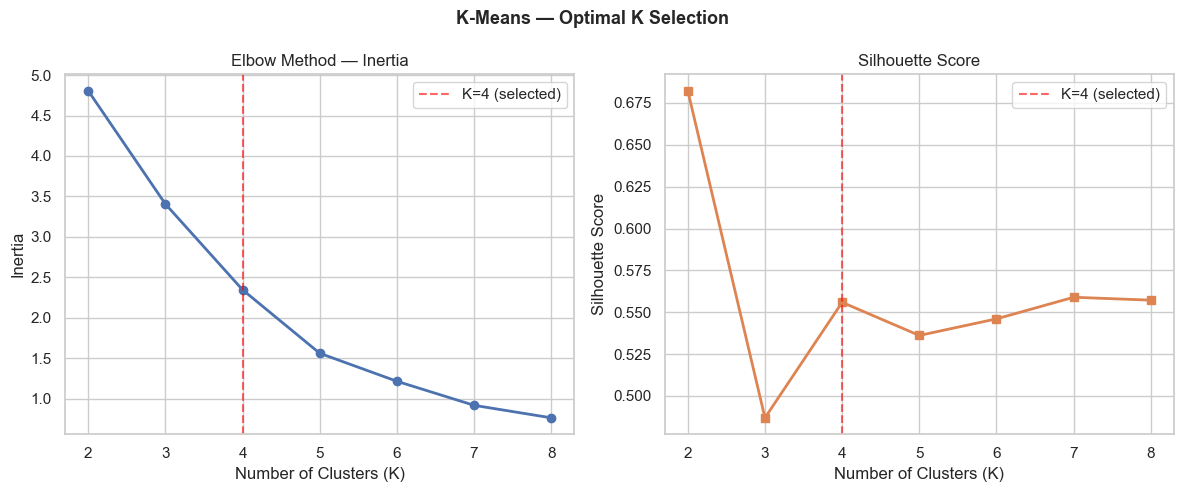

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("K-Means — Optimal K Selection", fontsize=13, fontweight="bold")

axes[0].plot(list(K_range), inertias, marker="o", color="#4C72B0", linewidth=2)
axes[0].axvline(x=4, color="red", linestyle="--", alpha=0.6, label="K=4 (selected)")
axes[0].set_title("Elbow Method — Inertia")
axes[0].set_xlabel("Number of Clusters (K)")
axes[0].set_ylabel("Inertia")
axes[0].legend()

axes[1].plot(list(K_range), silhouettes, marker="s", color="#DD8452", linewidth=2)
axes[1].axvline(x=4, color="red", linestyle="--", alpha=0.6, label="K=4 (selected)")
axes[1].set_title("Silhouette Score")
axes[1].set_xlabel("Number of Clusters (K)")
axes[1].set_ylabel("Silhouette Score")
axes[1].legend()

plt.tight_layout()
plt.savefig(f"{PROCESSED}analysis_02_elbow.png", dpi=150, bbox_inches="tight")
plt.show()

In [23]:
km_final = KMeans(n_clusters=4, random_state=42, n_init=10)
df["cluster_raw"] = km_final.fit_predict(X_scaled)

sil_final = silhouette_score(X_scaled, df["cluster_raw"])
print(f"Final Silhouette Score : {sil_final:.4f}")

# Map cluster numbers to business labels based on centroid positions
centroids = scaler.inverse_transform(km_final.cluster_centers_)
centroid_df = pd.DataFrame(centroids, columns=features)
centroid_df["cluster_raw"] = range(4)
print(f"\nCluster Centroids (original scale):")
print(centroid_df.to_string(index=False))

# Auto-label clusters based on HRS & stock_rate thresholds
hrs_mid   = df["health_risk_score"].median()
stock_mid = df["avg_stock_rate"].median()

def label_cluster(row):
    h = row["health_risk_score"]
    s = row["avg_stock_rate"]
    if h >= hrs_mid and s < stock_mid:   return "🔴 Critical Gap"
    elif h >= hrs_mid and s >= stock_mid: return "🟡 Well-Served"
    elif h < hrs_mid and s < stock_mid:  return "🟠 Underserved"
    else:                                 return "🟢 Surplus"

df["cluster_label"] = df.apply(label_cluster, axis=1)
df["priority_rank"] = df["cluster_label"].map({
    "🔴 Critical Gap": 1,
    "🟠 Underserved" : 2,
    "🟡 Well-Served" : 3,
    "🟢 Surplus"     : 4,
})

print(f"\nCluster Distribution:")
print(df["cluster_label"].value_counts().to_string())

print(f"\nCluster Stats:")
print(df.groupby("cluster_label")[
    ["health_risk_score","avg_stock_rate","total_revenue","total_units_sold"]
].mean().round(2).to_string())

Final Silhouette Score : 0.5559

Cluster Centroids (original scale):
 health_risk_score  avg_stock_rate  cluster_raw
         49.810000        0.867320            0
          3.153333        0.867229            1
         72.933200        0.879528            2
         72.488261        0.853245            3

Cluster Distribution:
cluster_label
🟡 Well-Served     30
🔴 Critical Gap    30
🟢 Surplus         24
🟠 Underserved     24

Cluster Stats:
                health_risk_score  avg_stock_rate  total_revenue  total_units_sold
cluster_label                                                                     
🔴 Critical Gap              67.79            0.85      198509.13          37936.87
🟠 Underserved               12.41            0.86      215305.22          40898.38
🟡 Well-Served               69.50            0.88      150598.56          28665.47
🟢 Surplus                   15.95            0.88      179214.92          34091.83


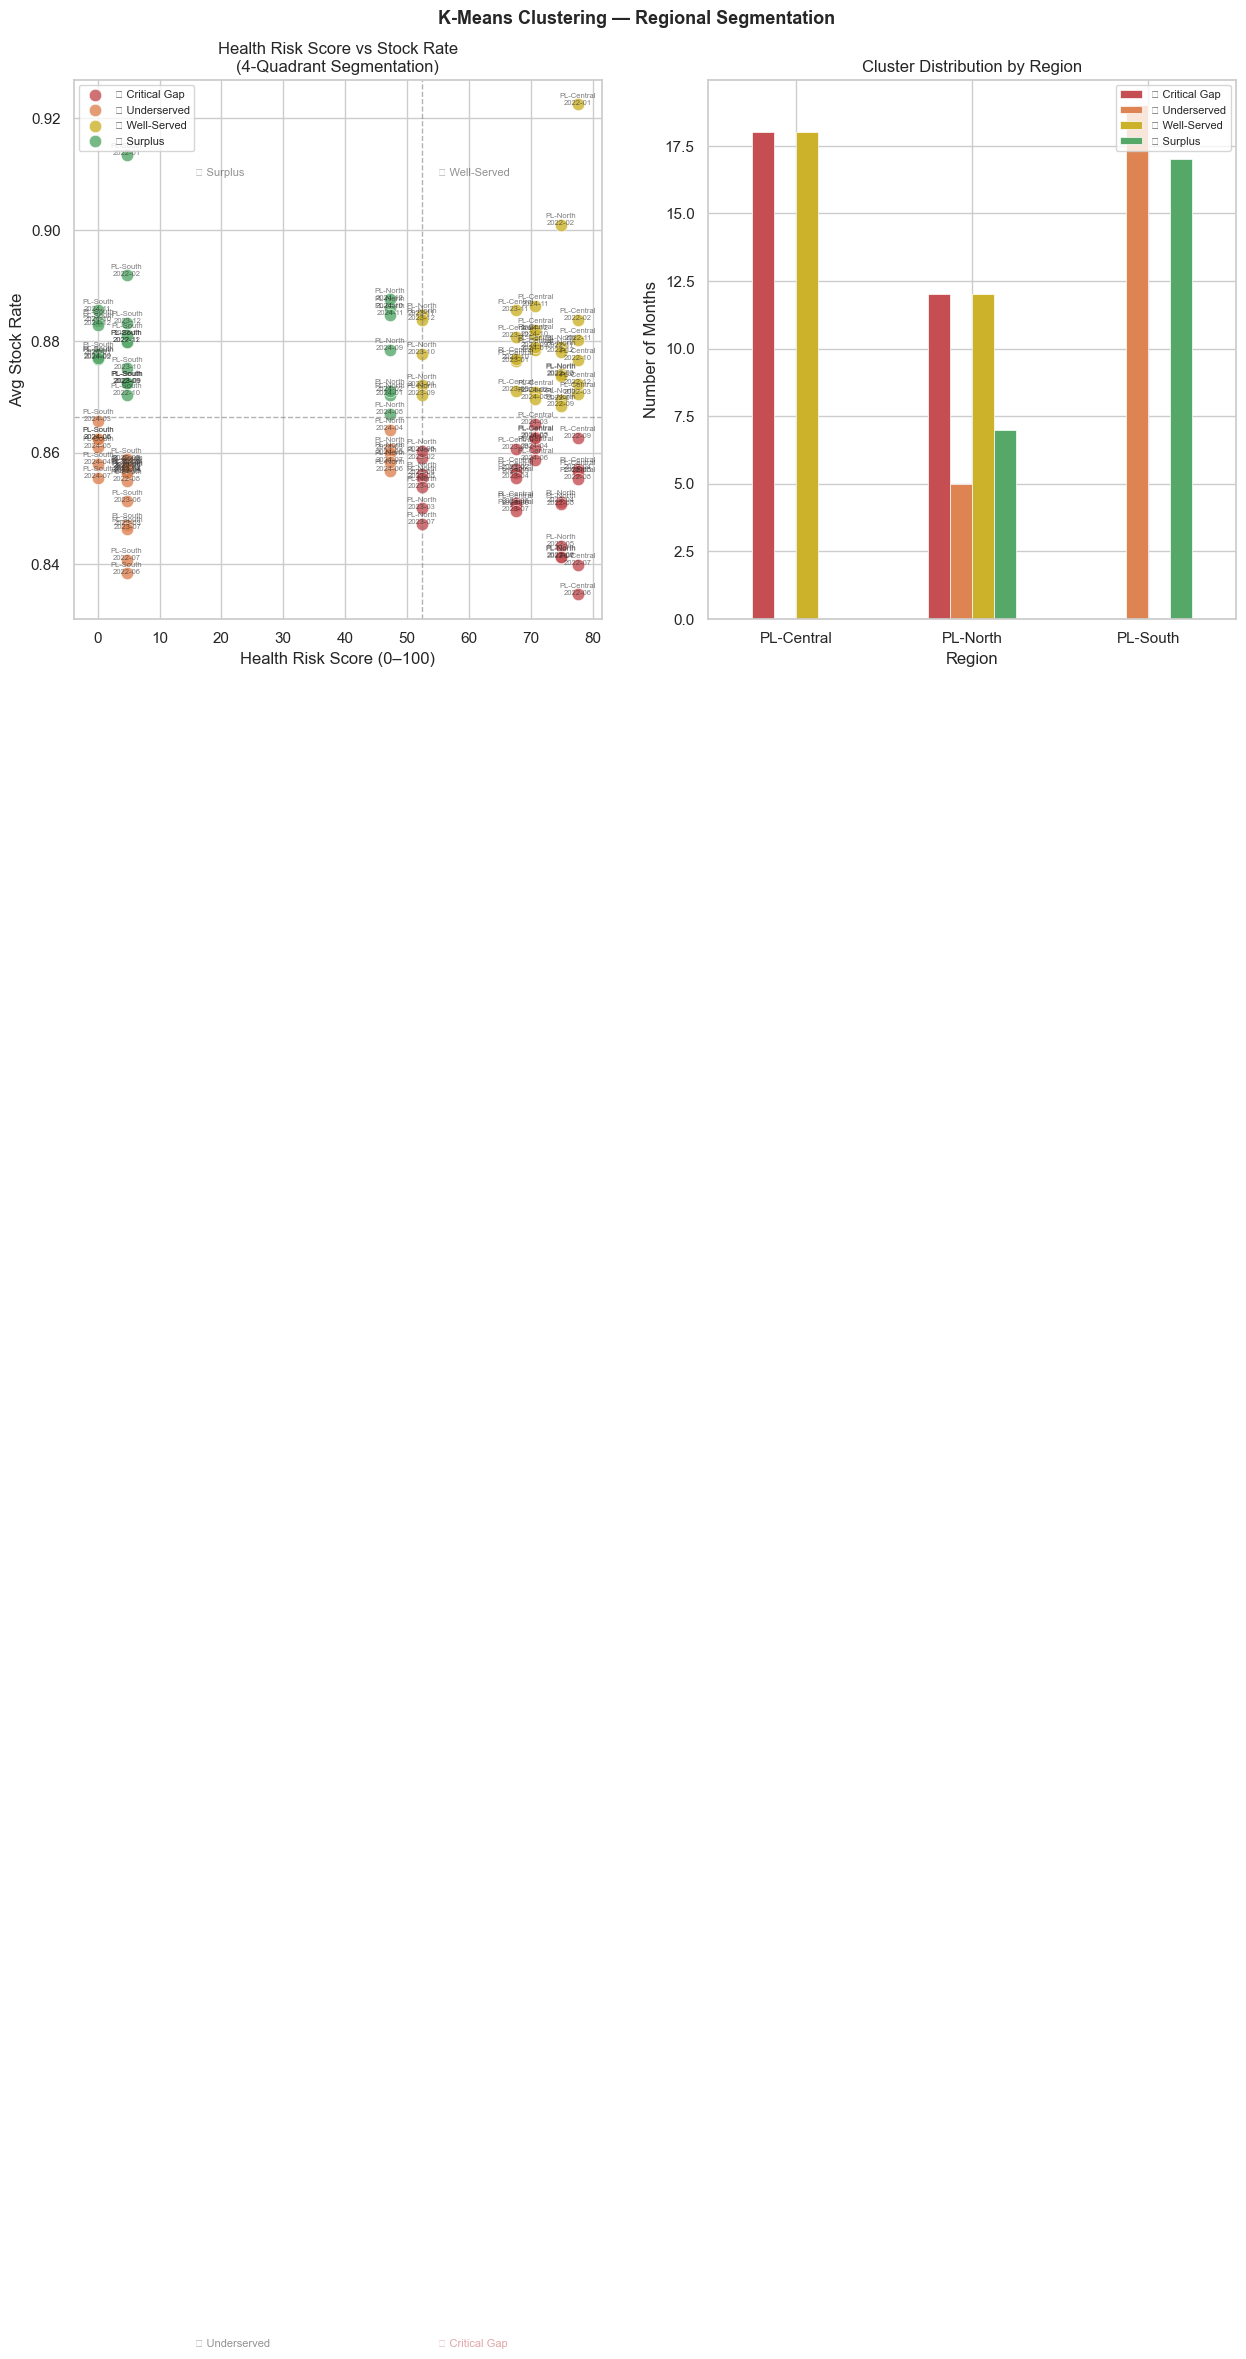

In [24]:
cluster_colors = {
    "🔴 Critical Gap": "#C44E52",
    "🟠 Underserved" : "#DD8452",
    "🟡 Well-Served" : "#CCB22B",
    "🟢 Surplus"     : "#55A868",
}

fig, axes = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle("K-Means Clustering — Regional Segmentation", fontsize=13, fontweight="bold")

# Left: scatter quadrant map
ax = axes[0]
for label, grp in df.groupby("cluster_label"):
    ax.scatter(grp["health_risk_score"], grp["avg_stock_rate"],
               label=label, color=cluster_colors[label],
               s=80, alpha=0.8, edgecolors="white", linewidth=0.5)
    # Annotate with region names
    for _, row in grp.iterrows():
        ax.annotate(f"{row['region']}\n{row['year_month']}",
                    xy=(row["health_risk_score"], row["avg_stock_rate"]),
                    fontsize=5.5, alpha=0.6, ha="center")

# Quadrant lines
ax.axvline(x=hrs_mid,   color="grey", linestyle="--", linewidth=1, alpha=0.6)
ax.axhline(y=stock_mid, color="grey", linestyle="--", linewidth=1, alpha=0.6)

# Quadrant labels
ax.text(hrs_mid * 0.3,  stock_mid * 1.05, "🟢 Surplus",        fontsize=8, alpha=0.5)
ax.text(hrs_mid * 1.05, stock_mid * 1.05, "🟡 Well-Served",    fontsize=8, alpha=0.5)
ax.text(hrs_mid * 0.3,  stock_mid * 0.6,  "🟠 Underserved",    fontsize=8, alpha=0.5)
ax.text(hrs_mid * 1.05, stock_mid * 0.6,  "🔴 Critical Gap",   fontsize=8, alpha=0.5, color="#C44E52")

ax.set_title("Health Risk Score vs Stock Rate\n(4-Quadrant Segmentation)")
ax.set_xlabel("Health Risk Score (0–100)")
ax.set_ylabel("Avg Stock Rate")
ax.legend(loc="upper left", fontsize=8)

# Right: stacked bar by region & cluster
cluster_region = df.groupby(["region", "cluster_label"]).size().unstack(fill_value=0)
cluster_region.plot(kind="bar", ax=axes[1], color=list(cluster_colors.values()),
                    edgecolor="white", linewidth=0.5)
axes[1].set_title("Cluster Distribution by Region")
axes[1].set_xlabel("Region")
axes[1].set_ylabel("Number of Months")
axes[1].tick_params(axis="x", rotation=0)
axes[1].legend(loc="upper right", fontsize=8)

plt.tight_layout()
plt.savefig(f"{PROCESSED}analysis_03_clustering.png", dpi=150, bbox_inches="tight")
plt.show()

In [25]:
# Revenue Gap = potential revenue in Critical Gap zones
# Logic: if a region has High Health Risk but Low Stock,
# what additional revenue could be captured if stock matched demand?

# Avg revenue per unit across all regions
avg_rev_per_unit = df["total_revenue"].sum() / df["total_units_sold"].sum()
print(f"  Avg Revenue per Unit : {avg_rev_per_unit:.2f}")

# For Critical Gap rows: estimate unmet demand
# Unmet demand = avg units sold in Well-Served (same HRS level) - actual units sold
well_served_avg = df[df["cluster_label"] == "🟡 Well-Served"]["total_units_sold"].mean()
critical_gap    = df[df["cluster_label"] == "🔴 Critical Gap"].copy()

critical_gap["unmet_demand"]   = (well_served_avg - critical_gap["total_units_sold"]).clip(lower=0)
critical_gap["potential_rev"]  = critical_gap["unmet_demand"] * avg_rev_per_unit
critical_gap["revenue_gap_pct"] = (
    critical_gap["potential_rev"] / critical_gap["total_revenue"] * 100
).round(1)

total_gap = critical_gap["potential_rev"].sum()
print(f"\n  Critical Gap rows    : {len(critical_gap)}")
print(f"  Total Potential Lost Revenue: {total_gap:,.2f}")
print(f"\nTop Critical Gap Periods:")
print(critical_gap[["year_month","region","total_units_sold","unmet_demand",
                     "potential_rev","health_risk_score"]].sort_values(
    "potential_rev", ascending=False).head(10).to_string(index=False))

  Avg Revenue per Unit : 5.25

  Critical Gap rows    : 30
  Total Potential Lost Revenue: 521,521.75

Top Critical Gap Periods:
year_month     region  total_units_sold  unmet_demand  potential_rev  health_risk_score
   2022-04 PL-Central             11242  17423.466667   91487.330871              77.67
   2022-04   PL-North             11273  17392.466667   91324.555729              74.89
   2022-05 PL-Central             17650  11015.466667   57840.133821              77.67
   2022-05   PL-North             18186  10479.466667   55025.699112              74.89
   2022-06 PL-Central             20628   8037.466667   42203.218588              77.67
   2022-09 PL-Central             21002   7663.466667   40239.415265              77.67
   2022-06   PL-North             21485   7180.466667   37703.273540              74.89
   2022-08 PL-Central             22917   5748.466667   30184.112151              77.67
   2022-08   PL-North             23331   5334.466667   28010.276387           

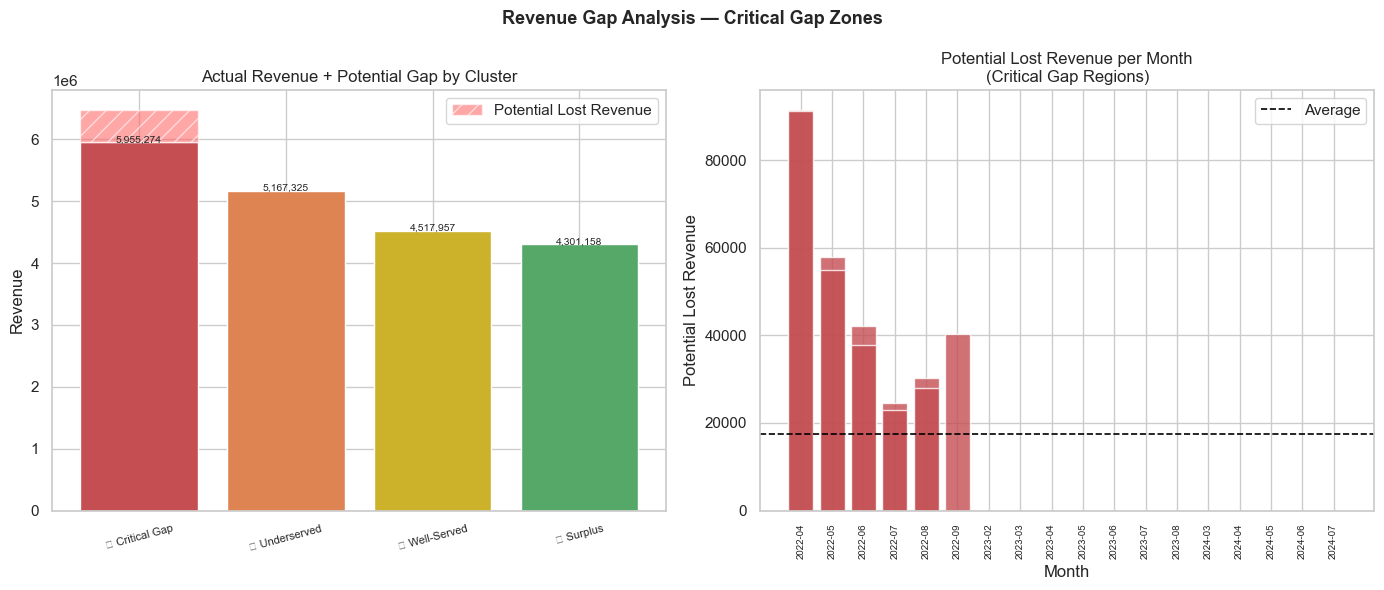

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Revenue Gap Analysis — Critical Gap Zones", fontsize=13, fontweight="bold")

# Left: Actual vs Potential revenue by cluster
cluster_rev = df.groupby("cluster_label")[["total_revenue","total_units_sold"]].sum()
cluster_rev["potential_rev"] = cluster_rev.index.map(
    lambda x: critical_gap["potential_rev"].sum() if x == "🔴 Critical Gap" else 0)

bars = axes[0].bar(cluster_rev.index, cluster_rev["total_revenue"],
                   color=list(cluster_colors.values()), edgecolor="white")
# Add potential on top of Critical Gap bar
cg_idx = list(cluster_rev.index).index("🔴 Critical Gap")
axes[0].bar(["🔴 Critical Gap"], [critical_gap["potential_rev"].sum()],
            bottom=[cluster_rev.loc["🔴 Critical Gap","total_revenue"]],
            color="#FF6B6B", alpha=0.6, hatch="//", label="Potential Lost Revenue")
axes[0].set_title("Actual Revenue + Potential Gap by Cluster")
axes[0].set_ylabel("Revenue")
axes[0].tick_params(axis="x", rotation=15, labelsize=8)
axes[0].legend()
for bar in bars:
    h = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, h + 50,
                 f"{h:,.0f}", ha="center", fontsize=7.5)

# Right: Revenue gap over time for Critical Gap regions
if len(critical_gap) > 0:
    axes[1].bar(critical_gap["year_month"], critical_gap["potential_rev"],
                color="#C44E52", alpha=0.8)
    axes[1].set_title("Potential Lost Revenue per Month\n(Critical Gap Regions)")
    axes[1].set_xlabel("Month")
    axes[1].set_ylabel("Potential Lost Revenue")
    axes[1].tick_params(axis="x", rotation=90, labelsize=7)
    axes[1].axhline(y=critical_gap["potential_rev"].mean(),
                    color="black", linestyle="--", linewidth=1.2, label="Average")
    axes[1].legend()

plt.tight_layout()
plt.savefig(f"{PROCESSED}analysis_04_revenue_gap.png", dpi=150, bbox_inches="tight")
plt.show()

In [27]:
# Full clustering results
clustering_results = df[[
    "year_month","year","month","region",
    "total_units_sold","total_revenue","total_gross_margin",
    "avg_stock_rate","avg_stock_available",
    "health_risk_score","avg_health_complaint_pct",
    "risk_category","stock_category","strategic_quadrant",
    "cluster_label","priority_rank",
    "is_rainy_season","is_ramadan","is_dengue_peak","demand_pressure_index"
]].copy()
clustering_results.to_csv(f"{PROCESSED}clustering_results.csv", index=False)
print(f"clustering_results.csv  : {clustering_results.shape}")

# Revenue gap summary
rev_gap_export = critical_gap[[
    "year_month","region","total_units_sold","total_revenue",
    "unmet_demand","potential_rev","revenue_gap_pct","health_risk_score"
]].sort_values("potential_rev", ascending=False)
rev_gap_export.to_csv(f"{PROCESSED}revenue_gap.csv", index=False)
print(f"revenue_gap.csv         : {rev_gap_export.shape}")

clustering_results.csv  : (108, 20)
revenue_gap.csv         : (30, 8)


In [28]:
print(f"Silhouette Score  : {sil_final:.4f}")
print(f"Correlation (HRS↔Sales): r={corr:.4f}, p={pval:.4f}")
print(f"Critical Gap rows : {len(critical_gap)}")
print(f"Total Revenue Gap : {total_gap:,.2f}")

Silhouette Score  : 0.5559
Correlation (HRS↔Sales): r=-0.2959, p=0.0019
Critical Gap rows : 30
Total Revenue Gap : 521,521.75
